In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e1/sample_submission.csv
/kaggle/input/playground-series-s5e1/train.csv
/kaggle/input/playground-series-s5e1/test.csv


# Importing Libraries 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, classification_report,confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import uniform, randint
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error

# Data Loading

In [3]:
train_data=pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv')

# EDA

In [4]:
train_data

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
...,...,...,...,...,...,...
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


In [6]:
train_data.isnull().sum()

id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64

In [7]:
new_train=train_data.dropna().reset_index(drop=True)

In [8]:
new_train

,id,date,country,store,product,num_sold
0,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
1,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
2,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
3,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
4,5,2010-01-01,Canada,Stickers for Less,Holographic Goose,300.0
...,...,...,...,...,...,...
221254,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0
221255,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0
221256,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0
221257,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0


In [9]:
new_train.isnull().sum()

id          0
date        0
country     0
store       0
product     0
num_sold    0
dtype: int64

In [10]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221259 entries, 0 to 221258
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        221259 non-null  int64  
 1   date      221259 non-null  object 
 2   country   221259 non-null  object 
 3   store     221259 non-null  object 
 4   product   221259 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.1+ MB


In [11]:
num_column=new_train.select_dtypes('float64')
cat_column=new_train.select_dtypes('object')
cat_column.drop(columns='date',inplace=True)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

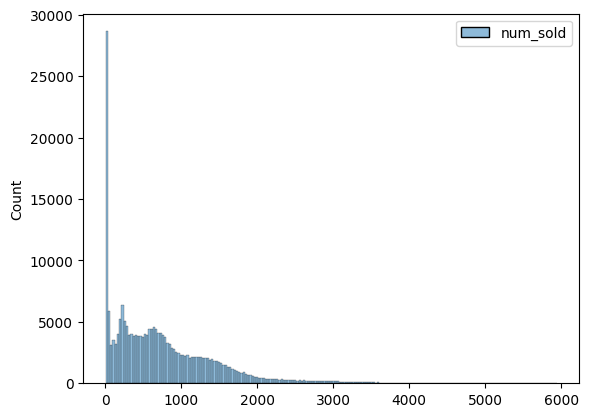

In [12]:
sns.histplot(data=num_column)

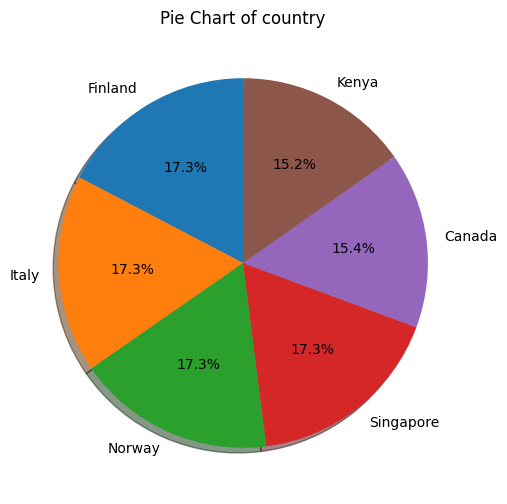

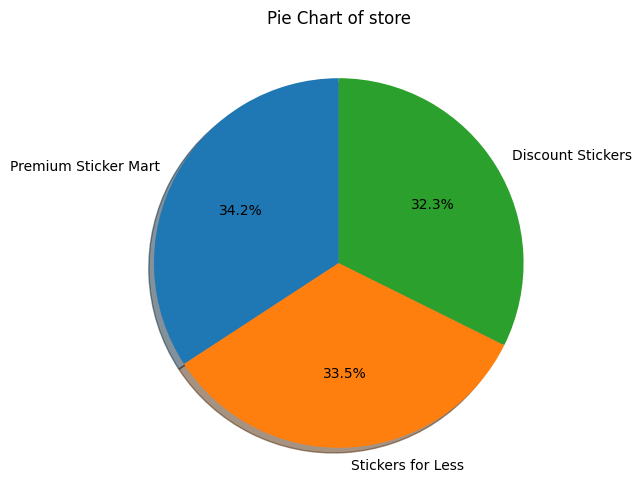

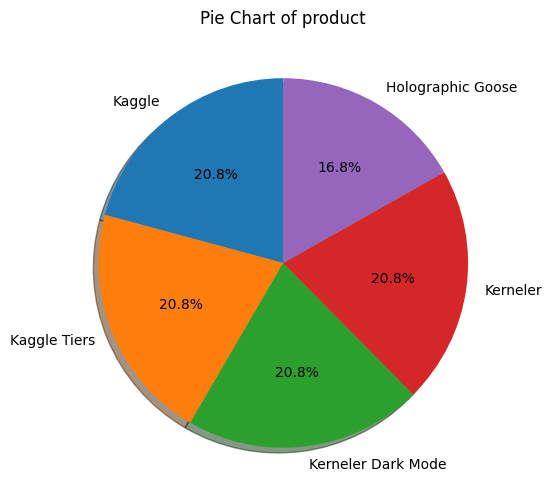

In [13]:
for col in cat_column.columns:
    plt.figure(figsize=(6, 6))
    cat_column[col].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, shadow=True)
    plt.title(f'Pie Chart of {col}')
    plt.ylabel('')
    plt.show()


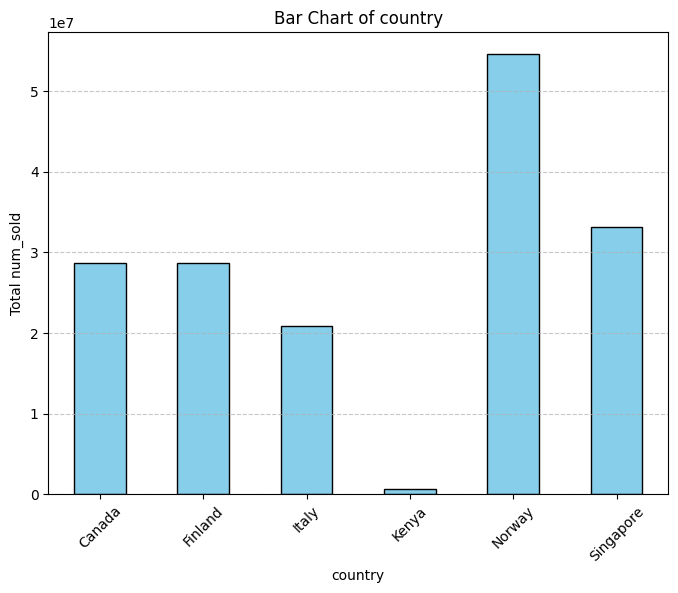

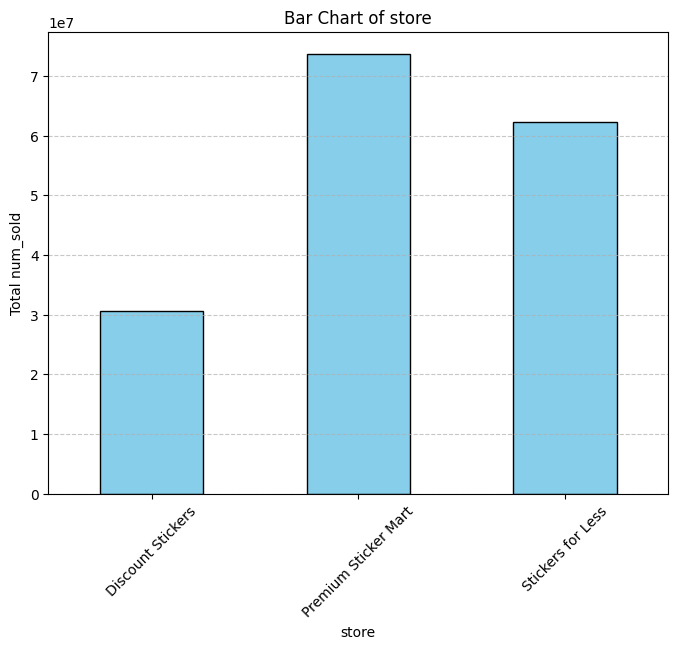

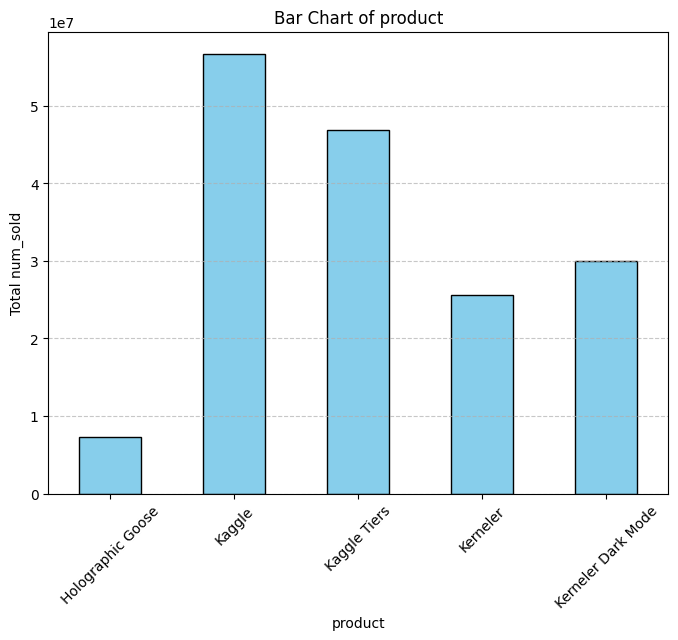

In [14]:
for col in cat_column.columns:
    plt.figure(figsize=(8, 6))  # Set figure size
    new_train.groupby(col)['num_sold'].sum().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Bar Chart of {col}')
    plt.ylabel('Total num_sold')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better readability
    plt.show()

In [15]:
chi2_scores = {}
for column in cat_column:
    contingency_table = pd.crosstab(new_train[column], new_train['num_sold']) 
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    chi2_scores[column] = chi2

chi2_df = pd.DataFrame(list(chi2_scores.items()), columns=['Feature', 'Chi-Square']).sort_values(by='Chi-Square', ascending=False)
print(chi2_df)

   Feature     Chi-Square
0  country  320050.229529
2  product  227485.961436
1    store   75106.817155


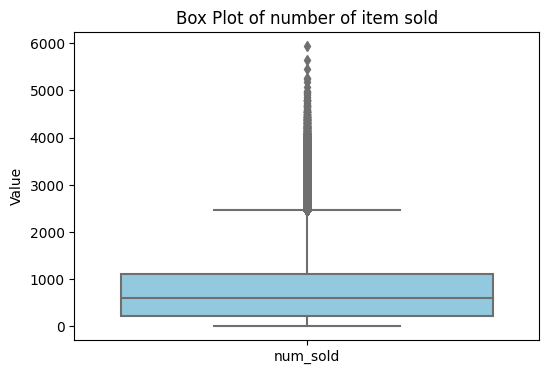

In [16]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=num_column, color='skyblue')
plt.title('Box Plot of number of item sold')
plt.ylabel('Value')
plt.show()

In [17]:
train_x = new_train.drop(columns=['id', 'num_sold'])
train_y = new_train['num_sold']

In [18]:
train_x

,date,country,store,product
0,2010-01-01,Canada,Discount Stickers,Kaggle
1,2010-01-01,Canada,Discount Stickers,Kaggle Tiers
2,2010-01-01,Canada,Discount Stickers,Kerneler
3,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode
4,2010-01-01,Canada,Stickers for Less,Holographic Goose
...,...,...,...,...
221254,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose
221255,2016-12-31,Singapore,Premium Sticker Mart,Kaggle
221256,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers
221257,2016-12-31,Singapore,Premium Sticker Mart,Kerneler


In [19]:
train_y

0          973.0
1          906.0
2          423.0
3          491.0
4          300.0
           ...  
221254     466.0
221255    2907.0
221256    2299.0
221257    1242.0
221258    1622.0
Name: num_sold, Length: 221259, dtype: float64

# Feature Engineering

In [20]:
train_x['date'] = pd.to_datetime(train_x['date'])
train_x['Year'] = train_x['date'].dt.year
train_x['Month'] = train_x['date'].dt.month
train_x['Day'] = train_x['date'].dt.day
train_x['weekday'] = train_x['date'].dt.weekday  # 0 = Monday, 6 = Sunday
train_x['is_weekend'] = train_x['weekday'].apply(lambda x: 1 if x >= 5 else 0)

In [21]:
train_x

,date,country,store,product,Year,Month,Day,weekday,is_weekend
0,2010-01-01,Canada,Discount Stickers,Kaggle,2010,1,1,4,0
1,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,2010,1,1,4,0
2,2010-01-01,Canada,Discount Stickers,Kerneler,2010,1,1,4,0
3,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,2010,1,1,4,0
4,2010-01-01,Canada,Stickers for Less,Holographic Goose,2010,1,1,4,0
...,...,...,...,...,...,...,...,...,...
221254,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,2016,12,31,5,1
221255,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2016,12,31,5,1
221256,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2016,12,31,5,1
221257,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,2016,12,31,5,1


In [22]:
train_x.drop(columns=['date'],inplace=True)

In [23]:
train_x

,country,store,product,Year,Month,Day,weekday,is_weekend
0,Canada,Discount Stickers,Kaggle,2010,1,1,4,0
1,Canada,Discount Stickers,Kaggle Tiers,2010,1,1,4,0
2,Canada,Discount Stickers,Kerneler,2010,1,1,4,0
3,Canada,Discount Stickers,Kerneler Dark Mode,2010,1,1,4,0
4,Canada,Stickers for Less,Holographic Goose,2010,1,1,4,0
...,...,...,...,...,...,...,...,...
221254,Singapore,Premium Sticker Mart,Holographic Goose,2016,12,31,5,1
221255,Singapore,Premium Sticker Mart,Kaggle,2016,12,31,5,1
221256,Singapore,Premium Sticker Mart,Kaggle Tiers,2016,12,31,5,1
221257,Singapore,Premium Sticker Mart,Kerneler,2016,12,31,5,1


In [24]:
train_x.Year.value_counts()

Year
2014    31823
2016    31767
2013    31721
2012    31719
2015    31643
2011    31445
2010    31141
Name: count, dtype: int64

# Preprocess the dataset by scaling numerical features and encoding categorical features with pipeline and column transformer.

In [25]:
categorical_features = ['country','store','product']
numeric_features = ['Year','Month','Day','weekday','is_weekend']
numeric_transformer = Pipeline(steps=[ 
    ('scaler', StandardScaler())  
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))  
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
]).set_output(transform='pandas')

# Splitting the dataset

In [26]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [27]:
x_train_p=preprocessor.fit_transform(X_train)
x_test_p=preprocessor.transform(X_test)

In [28]:
x_train_p

,num__Year,num__Month,num__Day,num__weekday,num__is_weekend,cat__country_Finland,cat__country_Italy,cat__country_Kenya,cat__country_Norway,cat__country_Singapore,cat__store_Premium Sticker Mart,cat__store_Stickers for Less,cat__product_Kaggle,cat__product_Kaggle Tiers,cat__product_Kerneler,cat__product_Kerneler Dark Mode
105179,-0.002947,-0.441297,-1.220526,1.493082,1.571833,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
35062,-1.004272,-1.308450,-0.083748,-1.005504,-0.636200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8150,-1.504934,-0.730348,-1.106848,-1.005504,-0.636200,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
52514,-1.004272,0.714908,-1.106848,-1.005504,-0.636200,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
115743,-0.002947,0.714908,-1.220526,-0.006070,-0.636200,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,-0.002947,1.003959,0.825674,-0.505787,-0.636200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
103694,-0.002947,-0.730348,0.257285,-0.006070,-0.636200,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131932,0.497715,-1.019399,-0.765815,1.493082,1.571833,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
146867,0.497715,0.425857,1.394063,-0.006070,-0.636200,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Model-1(XGBRegressor)

In [29]:
model1=XGBRegressor(n_estimators=2000,random_state=42)
model1.fit(x_train_p,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [30]:
y_pred1 = model1.predict(x_test_p)
mape_score1 = mean_absolute_percentage_error(y_test, y_pred1)
print(mape_score1)

0.14422026800500656


In [31]:
r2_score1 = model1.score(x_test_p, y_test)
print(f'R² Score: {r2_score1:.4f}')

R² Score: 0.9929


# XGBRegressor with hyperparameter tuning

In [32]:
model2=XGBRegressor(n_estimators=2000,random_state=42)

param_grid = {'learning_rate': [.01,.05],'max_depth': [5,8]}

grid_search2 = GridSearchCV(model2, param_grid, cv=3, n_jobs=-1, verbose=0)

grid_search2.fit(x_train_p, y_train)

print("Best Parameters: ", grid_search2.best_params_)

y_pred2 = grid_search2.predict(x_test_p)

mape2 = mean_absolute_percentage_error(y_test, y_pred2)
print(mape2)

Best Parameters:  {'learning_rate': 0.05, 'max_depth': 8}
0.09995422788324167


In [33]:
r2_score = grid_search2.score(x_test_p, y_test)
print(f'R² Score: {r2_score:.4f}')

R² Score: 0.9931


# Model-2(LightGBM)

In [34]:
from lightgbm import LGBMRegressor
model3 = LGBMRegressor(random_state=42)
model3.fit(x_train_p, y_train)
y_pred3 = model3.predict(x_test_p)
mape3 = mean_absolute_percentage_error(y_test, y_pred3)
print(mape3)
r2_score3 = model3.score(x_test_p, y_test)
print(f'R² Score: {r2_score3:.4f}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 177007, number of used features: 16
[LightGBM] [Info] Start training from score 751.724474
0.19689805229092938
R² Score: 0.9894


# LightGBM with hyperparameter tuning

In [35]:
model4=LGBMRegressor(n_estimators=2000,random_state=42)
param_grid = {'learning_rate': [.01,.05],'max_depth': [5,8]}
grid_search4 = GridSearchCV(model4, param_grid, cv=3, n_jobs=-1, verbose=0)
grid_search4.fit(x_train_p, y_train)
print("Best Parameters: ", grid_search4.best_params_)
y_pred4 = grid_search4.predict(x_test_p)
mape4 = mean_absolute_percentage_error(y_test, y_pred4)
print(mape4)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 177007, number of used features: 16
[LightGBM] [Info] Start training from score 751.724474
Best Parameters:  {'learning_rate': 0.05, 'max_depth': 8}
0.10617894897511036


Best Parameters:  {'learning_rate': 0.05, 'max_depth': 8}

mape4=0.10617894897511036

In [36]:
model5=LGBMRegressor(n_estimators=2000,random_state=42,max_depth=8,learning_rate=0.05,
                     reg_alpha=1,reg_lambda=1)
model5.fit(x_train_p, y_train)
y_pred5 = model5.predict(x_test_p)
mape5 = mean_absolute_percentage_error(y_test, y_pred5)
print(mape5)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 177007, number of used features: 16
[LightGBM] [Info] Start training from score 751.724474
0.10089572574187845


# Model-3 (Voting Regressor)

In [37]:
from sklearn.ensemble import VotingRegressor
vot = VotingRegressor(estimators=[('xgb', grid_search2),('lgbm', model5)])
vot.fit(x_train_p, y_train)
vot_pred = vot.predict(x_test_p)
mape_vot = mean_absolute_percentage_error(y_test, vot_pred)
print(mape_vot)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 177007, number of used features: 16
[LightGBM] [Info] Start training from score 751.724474
0.08579513259109693


# Performance comparision of three regression model

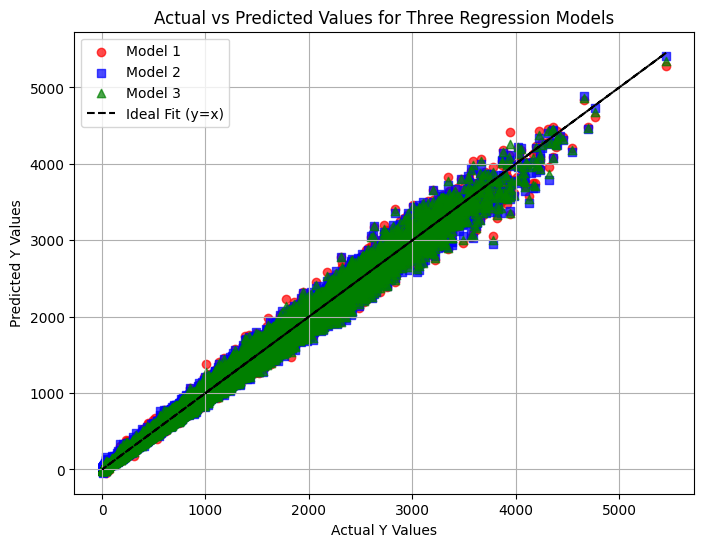

In [38]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred2, label="Model 1", marker='o', color='red', alpha=0.7)
plt.scatter(y_test, y_pred5, label="Model 2", marker='s', color='blue', alpha=0.7)
plt.scatter(y_test, vot_pred, label="Model 3", marker='^', color='green', alpha=0.7)
plt.plot(y_test, y_test, linestyle='--', color='black', label="Ideal Fit (y=x)")
plt.xlabel("Actual Y Values")
plt.ylabel("Predicted Y Values")
plt.title("Actual vs Predicted Values for Three Regression Models")
plt.legend()
plt.grid(True)
plt.show()

# TEST SET

In [39]:
Test=pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv')

In [40]:
Test

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode
...,...,...,...,...,...
98545,328675,2019-12-31,Singapore,Premium Sticker Mart,Holographic Goose
98546,328676,2019-12-31,Singapore,Premium Sticker Mart,Kaggle
98547,328677,2019-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers
98548,328678,2019-12-31,Singapore,Premium Sticker Mart,Kerneler


In [41]:
Test['date'] = pd.to_datetime(Test['date'])
Test['Year'] = Test['date'].dt.year
Test['Month'] = Test['date'].dt.month
Test['Day'] = Test['date'].dt.day
Test['weekday'] = Test['date'].dt.weekday  # 0 = Monday, 6 = Sunday
Test['is_weekend'] = Test['weekday'].apply(lambda x: 1 if x >= 5 else 0)

In [42]:
Test

,id,date,country,store,product,Year,Month,Day,weekday,is_weekend
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose,2017,1,1,6,1
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle,2017,1,1,6,1
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers,2017,1,1,6,1
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler,2017,1,1,6,1
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode,2017,1,1,6,1
...,...,...,...,...,...,...,...,...,...,...
98545,328675,2019-12-31,Singapore,Premium Sticker Mart,Holographic Goose,2019,12,31,1,0
98546,328676,2019-12-31,Singapore,Premium Sticker Mart,Kaggle,2019,12,31,1,0
98547,328677,2019-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2019,12,31,1,0
98548,328678,2019-12-31,Singapore,Premium Sticker Mart,Kerneler,2019,12,31,1,0


In [43]:
Test.drop(columns=['id','date'],inplace=True)

In [44]:
Test

,country,store,product,Year,Month,Day,weekday,is_weekend
0,Canada,Discount Stickers,Holographic Goose,2017,1,1,6,1
1,Canada,Discount Stickers,Kaggle,2017,1,1,6,1
2,Canada,Discount Stickers,Kaggle Tiers,2017,1,1,6,1
3,Canada,Discount Stickers,Kerneler,2017,1,1,6,1
4,Canada,Discount Stickers,Kerneler Dark Mode,2017,1,1,6,1
...,...,...,...,...,...,...,...,...
98545,Singapore,Premium Sticker Mart,Holographic Goose,2019,12,31,1,0
98546,Singapore,Premium Sticker Mart,Kaggle,2019,12,31,1,0
98547,Singapore,Premium Sticker Mart,Kaggle Tiers,2019,12,31,1,0
98548,Singapore,Premium Sticker Mart,Kerneler,2019,12,31,1,0


In [45]:
test=preprocessor.transform(Test)

In [46]:
test

,num__Year,num__Month,num__Day,num__weekday,num__is_weekend,cat__country_Finland,cat__country_Italy,cat__country_Kenya,cat__country_Norway,cat__country_Singapore,cat__store_Premium Sticker Mart,cat__store_Stickers for Less,cat__product_Kaggle,cat__product_Kaggle Tiers,cat__product_Kerneler,cat__product_Kerneler Dark Mode
0,1.999702,-1.597501,-1.675237,1.493082,1.571833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.999702,-1.597501,-1.675237,1.493082,1.571833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.999702,-1.597501,-1.675237,1.493082,1.571833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.999702,-1.597501,-1.675237,1.493082,1.571833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.999702,-1.597501,-1.675237,1.493082,1.571833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98545,3.001027,1.582061,1.735096,-1.005504,-0.636200,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
98546,3.001027,1.582061,1.735096,-1.005504,-0.636200,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
98547,3.001027,1.582061,1.735096,-1.005504,-0.636200,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
98548,3.001027,1.582061,1.735096,-1.005504,-0.636200,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [47]:
pred=vot.predict(test)

In [48]:
pred

array([ 145.66768792,  838.45962709,  785.25739889, ..., 1989.10973129,
       1120.18074014, 1319.1516433 ])

In [49]:
submission = pd.DataFrame({"id": range(230130,328680), 
                           "num_sold": pred}) 

submission.to_csv('submission.csv',index=False)